# Data Clearing

In [1]:
import pandas as pd

In [2]:
data = pd.read_excel('Customer_data - Intern.xlsx')

# Converting all column names to lowercase
data.columns = data.columns.str.lower()
# Droping
data = data.dropna(subset=['segment', 'churn'])
data = data.drop_duplicates()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4998 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subscriber_id         4998 non-null   int64  
 1   bnum_out              4510 non-null   float64
 2   bnum_in               4510 non-null   float64
 3   churn                 4998 non-null   int64  
 4   prod_cnt_macro        2173 non-null   float64
 5   rev_bun_mac           1022 non-null   float64
 6   rev_out               4490 non-null   float64
 7   usage_out_int_dur     4597 non-null   float64
 8   usage_out_offnet_dur  4597 non-null   float64
 9   usage_out_onnet_dur   4597 non-null   float64
 10  lne_tenure            4998 non-null   int64  
 11  topup_amt             2735 non-null   float64
 12  topup_cnt             3089 non-null   float64
 13  segment               4998 non-null   object 
dtypes: float64(10), int64(3), object(1)
memory usage: 585.7+ KB


## Checking the number of observations in each group for each feature

In [4]:
# Check the number of observations in each group for each feature
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.difference(['subscriber_id'])
group_sizes = {column: data.groupby('segment')[column].count() for column in numerical_columns}
group_sizes_df = pd.DataFrame(group_sizes)
group_sizes_df

,bnum_in,bnum_out,churn,lne_tenure,prod_cnt_macro,rev_bun_mac,rev_out,topup_amt,topup_cnt,usage_out_int_dur,usage_out_offnet_dur,usage_out_onnet_dur
segment,,,,,,,,,,,,
Segment 1,1017,1017,1081,1081,402,112,1081,336,436,1081,1081,1081
Segment 2,1403,1403,1410,1410,865,669,1407,1305,1341,1407,1407,1407
Segment 3,721,721,860,860,378,115,685,378,457,727,727,727
Segment 5,1369,1369,1647,1647,528,126,1317,716,855,1382,1382,1382


In [5]:
segment_counts = data['segment'].value_counts()
segment_proportions = segment_counts / len(data)
print(segment_counts)
print(segment_proportions)

# Calculate the distribution of churn within each segment
churn_distribution = data.groupby('segment')['churn'].value_counts(normalize=True).unstack()

# Add counts of records per segment for reference
churn_distribution['total_records'] = data['segment'].value_counts()

# Rename columns for clarity
churn_distribution.rename(columns={0: 'churn_0_percentage', 1: 'churn_1_percentage'}, inplace=True)
churn_distribution

segment
Segment 5    1647
Segment 2    1410
Segment 1    1081
Segment 3     860
Name: count, dtype: int64
segment
Segment 5    0.329532
Segment 2    0.282113
Segment 1    0.216287
Segment 3    0.172069
Name: count, dtype: float64


churn,churn_0_percentage,churn_1_percentage,total_records
segment,,,
Segment 1,NaN,1.000000,1081
Segment 2,0.997163,0.002837,1410
Segment 3,1.000000,NaN,860
Segment 5,1.000000,NaN,1647


## T-test

In [6]:
from scipy.stats import ttest_ind

churn = data['segment'].unique()

churn_0 = data[data['segment'] == churn[0]]
churn_1 = data[data['segment'] == churn[1]]
selected_features = data.select_dtypes(include=['float64', 'int64']).columns

churn_0 = churn_0[selected_features].dropna()
churn_1 = churn_1[selected_features].dropna()

# Результаты T-теста
t_test_results = {}
for feature in selected_features:
    if churn_0[feature].nunique() > 1 and churn_1[feature].nunique() > 1:
        stat, p_value = ttest_ind(churn_0[feature], churn_1[feature], nan_policy='omit')
        t_test_results[feature] = {'t-statistic': stat, 'p-value': p_value}
    else:
        t_test_results[feature] = {'t-statistic': None, 'p-value': None}

# Преобразование результатов в DataFrame
t_test_results_df = pd.DataFrame(t_test_results).T
display(t_test_results_df)

,t-statistic,p-value
subscriber_id,0.339682,0.734192
bnum_out,-5.060698,0.000001
bnum_in,-5.259052,0.0
churn,None,None
prod_cnt_macro,-8.233232,0.0
rev_bun_mac,-7.058526,0.0
rev_out,0.045495,0.963725
usage_out_int_dur,-0.271195,0.786316
usage_out_offnet_dur,-0.204285,0.838186
usage_out_onnet_dur,-5.914888,0.0


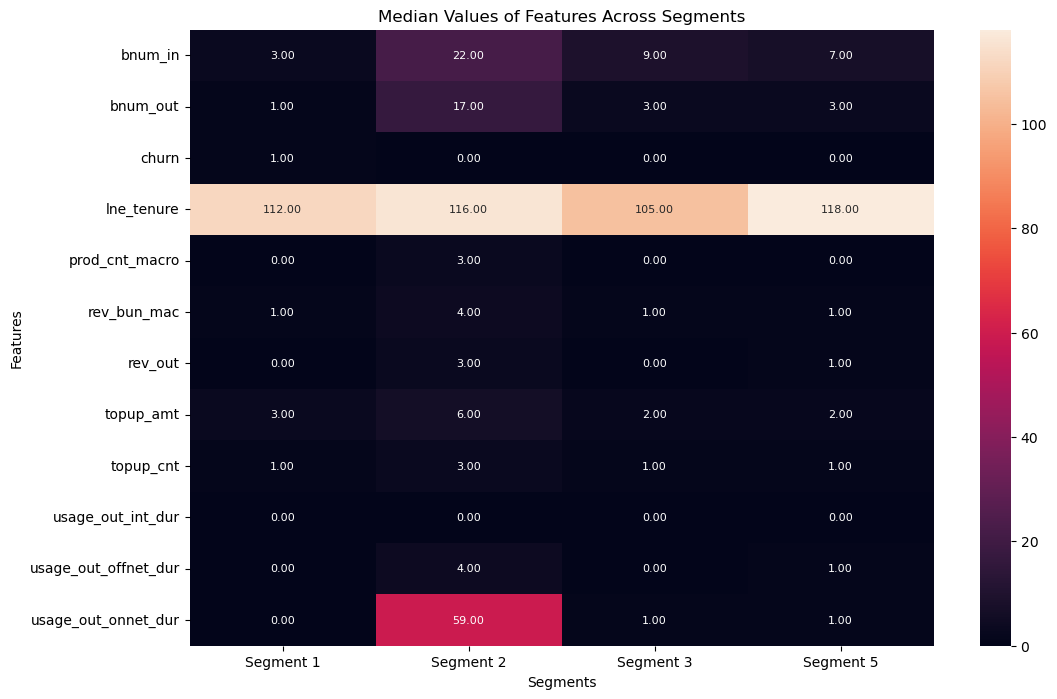

In [7]:
# Visualize the differences in feature medians across segments
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the median values of all numerical features by segment
segment_means = data.groupby('segment')[numerical_columns].median()
segment_means = segment_means.fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(segment_means.T, annot=True, fmt='.2f', cbar=True, annot_kws={'size': 8})
plt.title('Median Values of Features Across Segments')
plt.xlabel('Segments')
plt.ylabel('Features')
plt.show()

## Inferences

We can observe that churn rates vary across segments:
-	In segment 1, the churn rate is 100%.
- In the other segments, churn is absent (with a minor exception in segment 2).

This may indicate that the sample is biased compared to the general population.

It is necessary to refine the segmentation parameters. Collaboration with Data Engineers has helped improve the quality of the data for further investigation of our target user groups.

The results of the **T-testing** suggest that we cannot reject the null hypothesis, meaning there is no evidence to claim that the means differ.

# Forecasting Churn by features

In [8]:
data = data.fillna(0)

In [9]:
# Encode Segment
data['segment'] = data['segment'].astype('category').cat.codes

## Checking Data Normalization

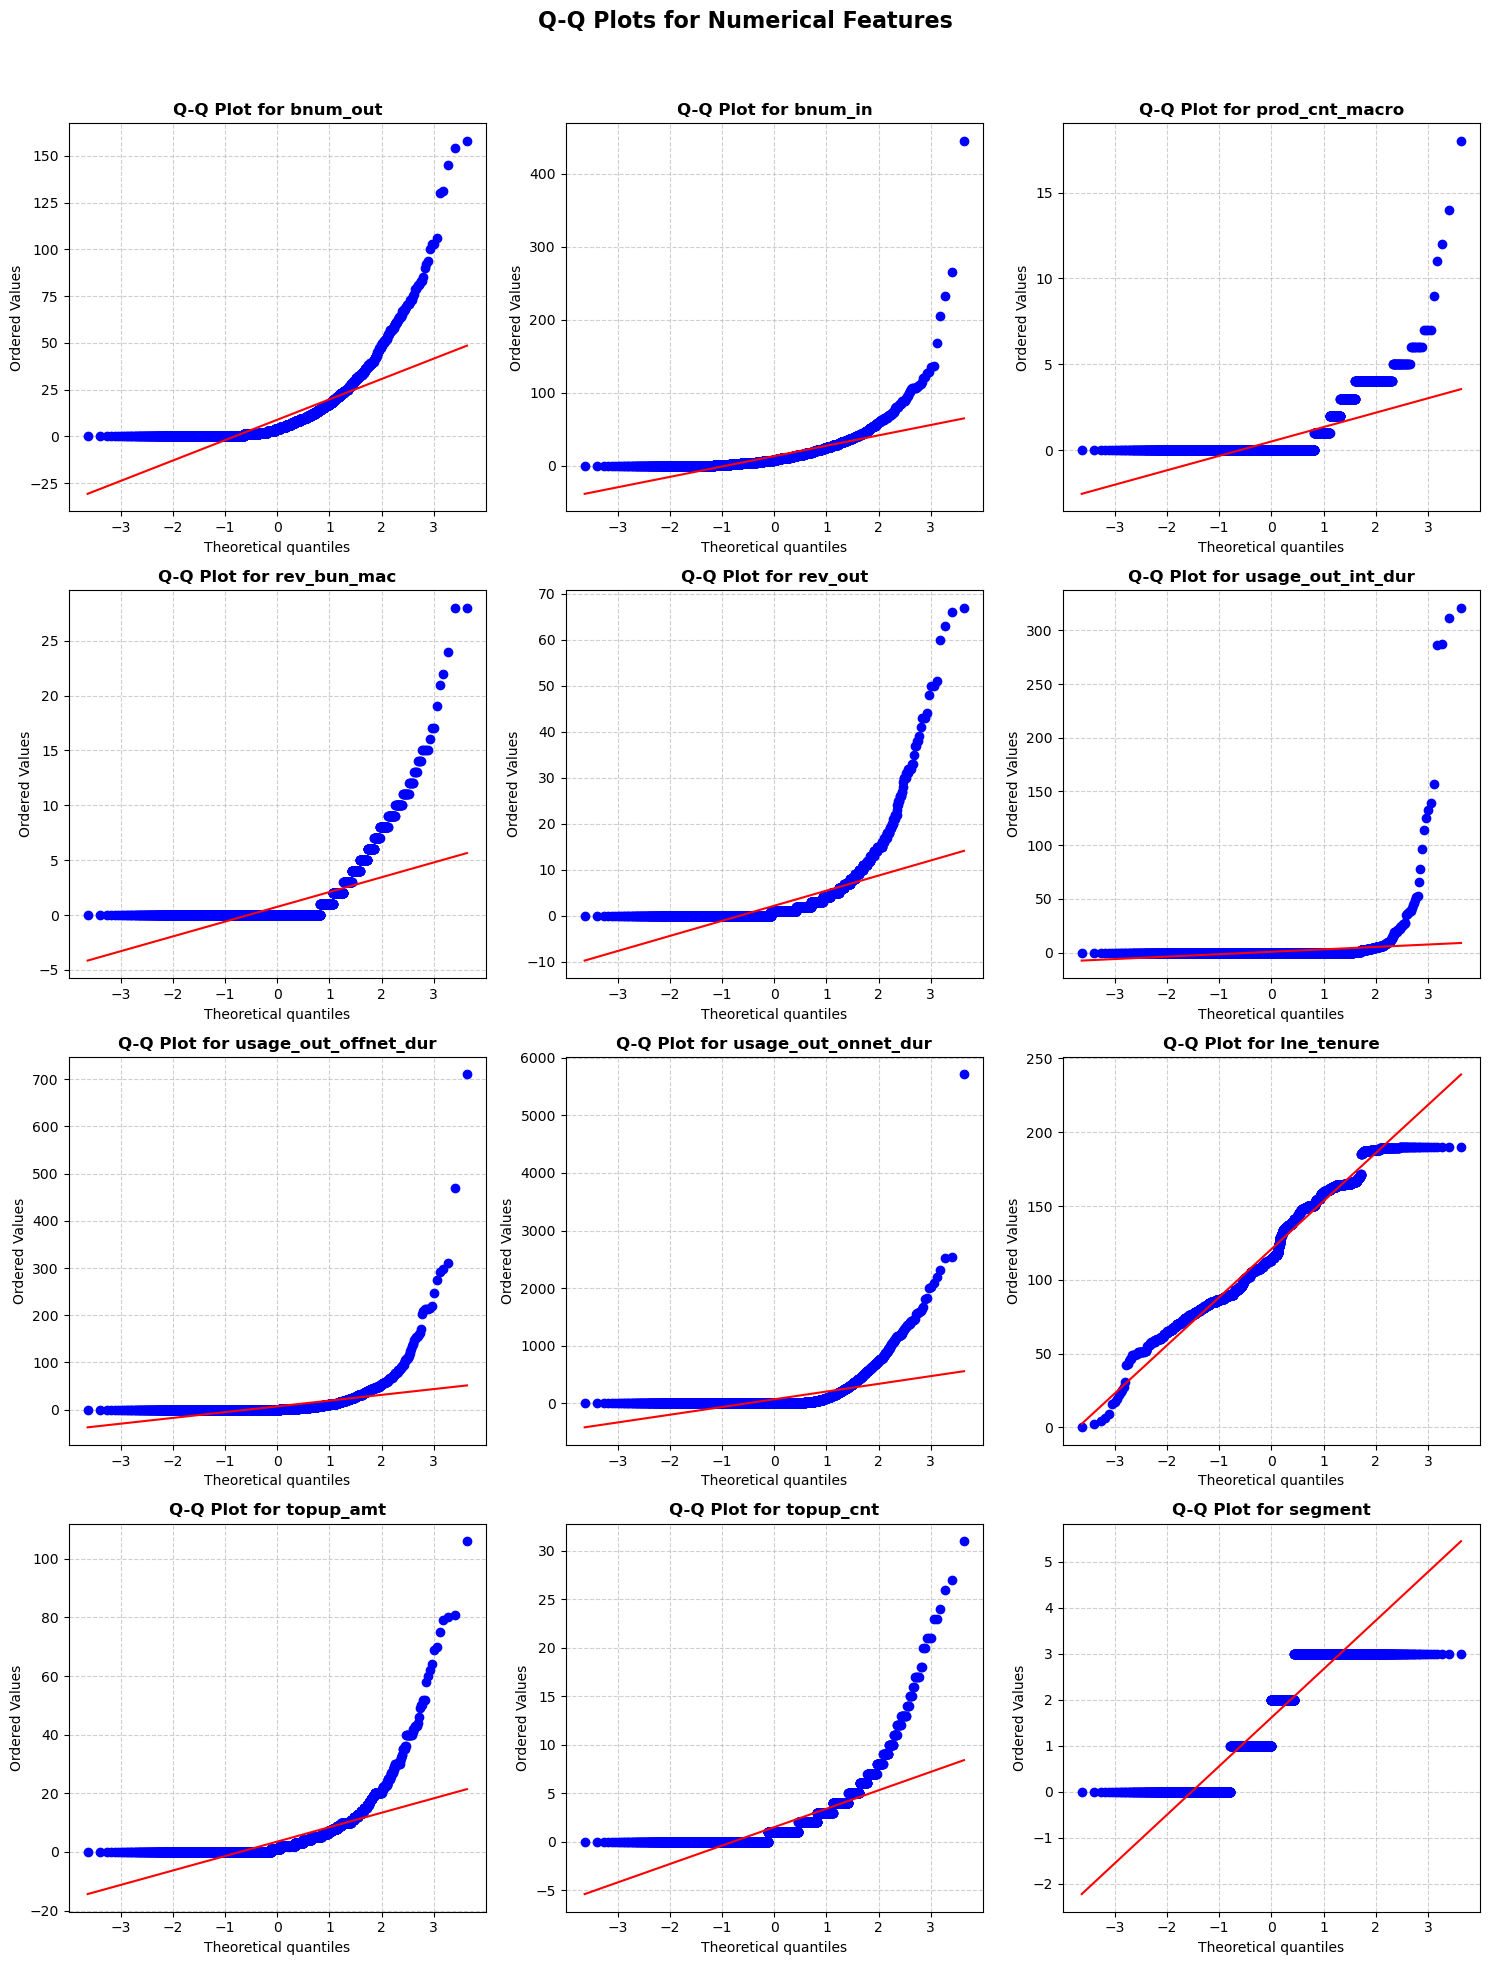

In [10]:
import scipy.stats as stats

columns = data.drop(columns=['subscriber_id', 'churn']).columns
n_cols = 3
n_rows = -(-len(columns) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

for i, column in enumerate(columns):
    row, col = divmod(i, n_cols)
    ax = axes[row, col] if n_rows > 1 else axes[col]
    stats.probplot(data[column], dist='norm', plot=ax)
    ax.set_title(f'Q-Q Plot for {column}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.6, linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=10)

if len(columns) < n_rows * n_cols:
    for i in range(len(columns), n_rows * n_cols):
        row, col = divmod(i, n_cols)
        ax = axes[row, col] if n_rows > 1 else axes[col]
        ax.axis('off')

plt.suptitle('Q-Q Plots for Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### The data is not normally distributed, and there are also dominant features present. The choice of model is clear: Gradient Boosting

## Creating New Features by Segments

In [11]:
# Calculate aggregated group metrics based on 'segment'
segment_group = data.groupby('segment')
data['avg_revenue_segment'] = data['segment'].map(segment_group['rev_out'].median())
data['avg_tenure_segment'] = data['segment'].map(segment_group['lne_tenure'].median())

# Deviation of customer activity time from the segment average
data['tenure_diff'] = data['lne_tenure'] - data['avg_tenure_segment']
#Frequency of replenishments relative to activity time
data['topup_rate'] = data['topup_cnt'] / (data['lne_tenure'] + 1)
# Ratio of outgoing to incoming calls
data['call_ratio'] = data['bnum_out'] / (data['bnum_in'] + 1)
# Ratio of call revenue to package revenue
data['revenue_ratio'] = data['rev_out'] / (data['rev_bun_mac'] + 1)
# Interaction between the number of recharges and the duration of outgoing calls
data['topup_usage_interaction'] = data['topup_cnt'] * data['usage_out_offnet_dur']

data = data.drop(columns=['avg_tenure_segment', 'avg_revenue_segment'])

## Building the model

[0]	validation_0-logloss:0.76909
[50]	validation_0-logloss:0.50553
[100]	validation_0-logloss:0.35913
[150]	validation_0-logloss:0.25396
[199]	validation_0-logloss:0.19354


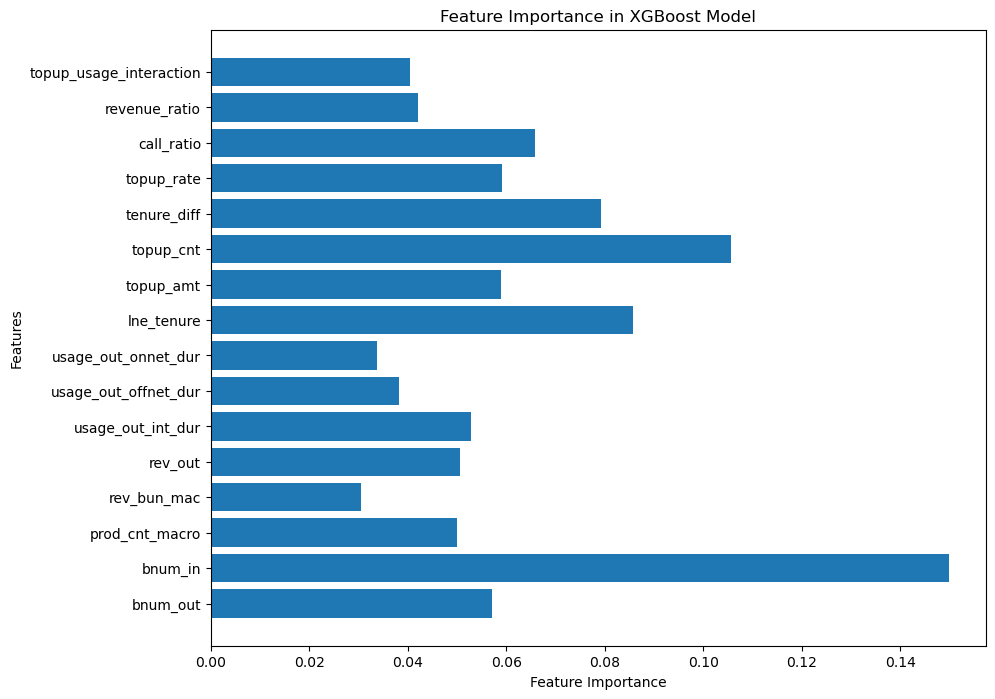

             Model Results             
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Parameter         ┃           Value ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ colsample_bytree  │             0.8 │
│ learning_rate     │             0.1 │
│ max_depth         │               4 │
│ n_estimators      │             200 │
│ reg_alpha         │               0 │
│ reg_lambda        │               1 │
│ scale_pos_weight  │               5 │
│ subsample         │             0.8 │
│ ROC AUC Score     │          0.9829 │
│ Cross-Val ROC AUC │ 0.9725 ± 0.0117 │
│ Precision         │          0.8609 │
│ Recall            │          0.9124 │
│ F1 Score          │          0.8859 │
└───────────────────┴─────────────────┘

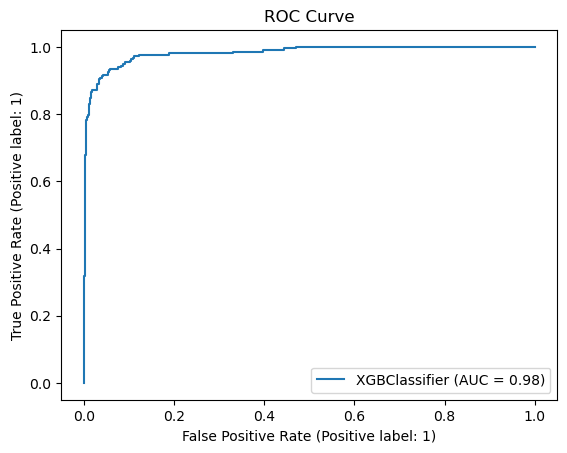

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from rich.console import Console
from rich.table import Table
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN

# Data Preparing
data_cleaned = data.drop(columns=['subscriber_id'])
X = data_cleaned.drop(columns=['churn', 'segment'])
y = data_cleaned['churn']

# X_resampled, y_resampled = ADASYN(random_state=42).fit_resample(X, y)

X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Cross-Validation Settings
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameters for GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2],
    'scale_pos_weight': [2, 3, 5]
}

xgb_model = xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=2,
    random_state=42
)

grid_search = GridSearchCV(xgb_model, param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = XGBClassifier(random_state=42, eval_metric='logloss', **best_params)
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50)

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(data_cleaned.drop(columns=['churn', 'segment']).columns, best_model.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in XGBoost Model')
plt.show()

# Cross-Validation Scores
cv_scores = cross_val_score(best_model, X_scaled, y, cv=cv, scoring='roc_auc', n_jobs=-1)

# Rich Table Output
def print_rich(best_params, auc_score, cv_mean, cv_std, precision, recall, f1):
    console = Console()
    table = Table(title='Model Results')
    table.add_column('Parameter', justify='left')
    table.add_column("Value", justify='right')

    for param, value in best_params.items():
        table.add_row(param, str(value))
        
    table.add_row('ROC AUC Score', f'{auc_score:.4f}')
    table.add_row('Cross-Val ROC AUC', f'{cv_mean:.4f} ± {cv_std:.4f}')
    table.add_row('Precision', f'{precision:.4f}')
    table.add_row('Recall', f'{recall:.4f}')
    table.add_row('F1 Score', f'{f1:.4f}')

    console.print(table)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print_rich(
    best_params=grid_search.best_params_,
    auc_score=roc_auc_score(y_test, y_pred_proba),
    cv_mean=cv_scores.mean(),
    cv_std=cv_scores.std(),
    precision=precision,
    recall=recall,
    f1=f1)

# Plot ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

In [13]:
precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

print(f'Class 0 (Churn=0) - Precision: {precision_0:.4f}, Recall: {recall_0:.4f}, F1-Score: {f1_0:.4f}')
print(f'Class 1 (Churn=1) - Precision: {precision_1:.4f}, Recall: {recall_1:.4f}, F1-Score: {f1_1:.4f}')

Class 0 (Churn=0) - Precision: 0.9753, Recall: 0.9591, F1-Score: 0.9672
Class 1 (Churn=1) - Precision: 0.8609, Recall: 0.9124, F1-Score: 0.8859
